## Diffusion model-implementation 
- [notebook1](https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=Rj17psVw7Shg)
- [notebook2](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=f70235f8)

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

if torch.__version__ != "2.0.0":
    raise Exception("Reconnect to the Correct Kernel")
else:
    print("You are connected to Kernel, Torch Version: ", torch.__version__)

You are connected to Kernel, Torch Version:  2.0.0


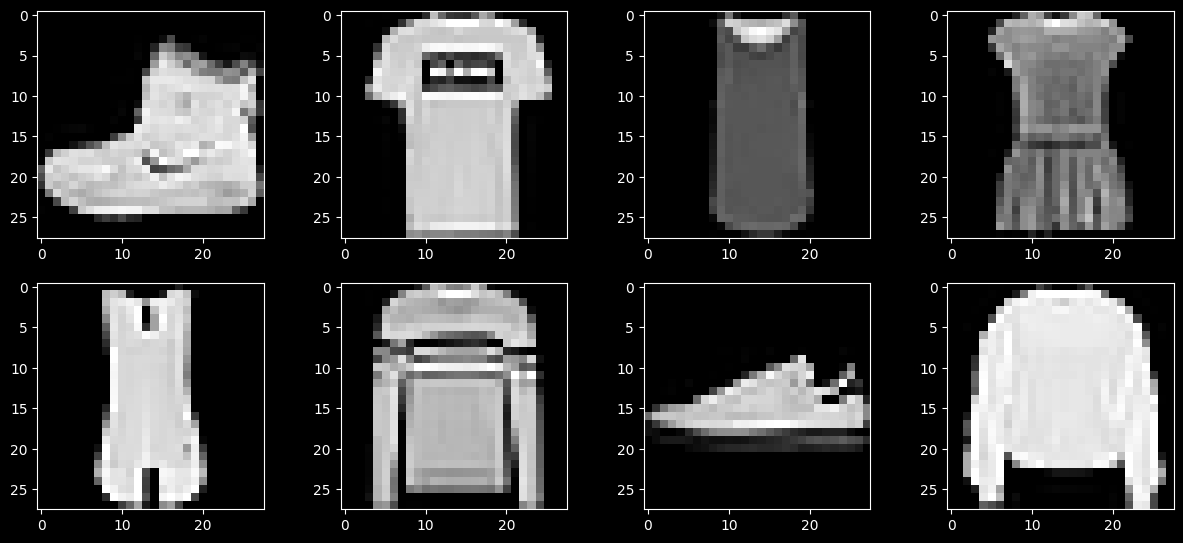

In [2]:
data  = torchvision.datasets.FashionMNIST(root='./data', download=True)

def Show_images(dataset, num_samples = 8, cols = 4):
    """plots some sample of the dataset"""
    plt.figure(figsize=(15, 10))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols)+1, cols, i+1) #* (rows, columns, image number)
        plt.imshow(img[0], cmap='gray')
Show_images(data)   

In [3]:
class_dict = data.class_to_idx
print("data shape: ", data.data.shape)
print("target shape: ", data.targets.shape)

data shape:  torch.Size([60000, 28, 28])
target shape:  torch.Size([60000])


## Loading data 



# Building diffusin model 

###  Noise scheduler -> forward pass 
- Noise can be precomputed and stored in a buffer
- Noise can be computed on the fly
- we can sample each timestep image independently
- No model parameters are updated during the forward pass
  - thus no mode is needed


forward pass:

- addding noise to the image on each timestep
- we can sample each timestep image independently

> warning : Math Dive

$$
q(x_{1:T}|x_0) = \prod_{t=1}^T q(x_t|x_{t-1})
$$

Noise On Sample =

$$
 q(x_t|x_{t-1}) = \mathcal{N}(x_t ; \sqrt{1-\beta_t}x_{t-1}, \beta_t I)
$$

contional gaussian distribution with a mean dependent on the previous timestep image and a specific variance

- $x_t$ is the image at timestep
- $x_{t-1}$ is the image at the previous timestep, less noisy
- $ \sqrt{1-\beta*t}x*{t-1} $ is the mean of the gaussian distribution

  - mean of the distribution = previous image \* noise level (depends on the variance sheduler $\beta_t$)

- $\beta_t I$ is the variance of the distribution, which is set to a constant value $\beta_t$ times the identity matrix $I$
- $ \beta $ controls how fast we converge toward a mean of zero which crossponds to a standard gaussian distribution
- `Add the right Amount of noise to the image at each timestep`
- we can sample each timestep image independently, we don't need to sample the whole sequence at once

  - base on $x_0$ we can sample $x_t$ for any $t$
    $$
    q(x_t|x_0) = N(x_t; \sqrt{\bar{\alpha_t}}x_0, (1-\bar{\alpha_t})I)
    $$
    where $\alpha_t$ is $1 - \sum{beta_t}$ which is the total amount of image left after all the noise is added
    , $\bar{\alpha_t}$ is the cumulative sum of the reciprocal of $\alpha_t$ from $t=1$ to $t=T$
    $$
      x_t = \sqrt{\bar{\alpha_t}}x_0 + \sqrt{1-\alpha_t} *Noise
    $$

  $$

[more details](https://www.youtube.com/watch?v=HoKDTa5jHvg&ab_channel=Outlier)


## Forward Pass

- set number of noise levels -> by Time step
- set noise level for each timestep
- Vecorize the noise levels

#### Steps

1. calculate the noise level $\beta$ for each timestep

   $$
     \beta = {x: start + (end - start) * x / (T-1), x = 0, 1, ..., T-1}
   $$

2. calculated the $\alpha$

$$
\alpha = 1 - \beta
$$

3. calculate the cumulative product of $\alpha$

$$
{\alpha_{cumprod}} = \prod_{t=1}^T \alpha_t
$$

4. calculate the cumulative product of alphas but the last noise level is set to 1 using padding

$$
\alpha_{previous-cumprod} = [1, {\alpha_{cumprod}}[0:T-1]]
$$

5. calculate square root of the reciprocal of $\alpha{cumprod}$

$$
\bar{\alpha} = \sqrt{\frac{1}{\alpha_{}}}
$$

6. calculate the square root of the cumulative product of $\alpha$

$$
\alpha_{sqrt-cumprod} = \sqrt{\alpha_{cumprod}} = \sqrt{\prod_{t=1}^T \alpha_t}
$$

7. calculated the square root of 1 minus the cumulative product of $\alpha$

$$
\alpha_{sqrt-one-minus-cumprod} = \sqrt{1 - \alpha_{cumprod}} = \sqrt{1 - \prod_{t=1}^T \alpha_t}
$$

8. Calculate the posterior varaince of the gaussian distribution
  
$$
\sigma_{posterior-variance} = \beta * \frac{1 - \alpha_{comprod-previous}}{1- \alpha_{cumprod}}


In [4]:

import torch.nn.functional as F

# * Step 1: create Noise levels, amount of noise to add
T = 25
START = 0.0001
END = 0.02

Betas = torch.linspace(START, END, T)

# * Step 2: create Alphas, amount of original image
Alphas = 1 - Betas

# * Step 3: calculate the cumulative product of alphas
Alphas_cumprod = torch.cumprod(Alphas, dim=0)

# * Step 4: calculate the cumulative product of Alphas but replace the last element with 1
Alphas_cumprod_prev = F.pad(Alphas[:-1], (1, 0), value=1)

# * Step 5: calculate the sqrt of the reciprocal of alphas
Alphas_sqrt_reciprocals = torch.sqrt(1 / Alphas)

# * Step 6: calculate the square root of cumulative product of Alphas
Alphas_sqrt_cumpord = torch.sqrt(torch.cumprod(Alphas, dim=0))

# * Step 7: calculate the square root of one minus cumulative product of Alphas
Alphas_sqrt_one_minus_cumprod = torch.sqrt(1 - torch.cumprod(Alphas, dim=0))

# * step 8: caclulate the postierior variance
postierior_variance = Betas * (1 - Alphas_cumprod_prev) / (1 - Alphas_cumprod)



In [5]:
def linear_beta_schedule(timestpes, start= 0.0001, end = 0.02):
    """linear beta schedule, all the beta values from start to end in timestpes"""
    return torch.linspace(start, end, timestpes)

def get_index_from_list(val, t, x_shape):
    """
    returns a specific index from a passed list of values
    while maintaining the shape of the original list
    """
    batch_size = t.shape[0] #* get the batch size
    out = val.gather(-1, t.cpu()) #* gather the values from the list & move to cpu
    #* reshape the output to match the shape of the input.
    return out.reshape(batch_size, *((1,)) * (len(x_shape) - 1)).to(t.device)



def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(Alphas_sqrt_cumpord, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(Alphas_sqrt_one_minus_cumprod, t, x_0.shape)
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


In [6]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms

IMG_SIZE = 28
BATCH_SIZE = 4


data_transforms =transforms.Compose([
        # transforms.Resize((IMG_SIZE, IMG_SIZE)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1),  # Scale between [-1, 1]
    ])
reverse_transforms = transforms.Compose([
            transforms.Lambda(lambda t: (t + 1) / 2),
            #transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
            transforms.Lambda(lambda t: t * 255.0),
            transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
            transforms.ToPILImage(),
        ])


data = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=data_transforms)
# dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [7]:
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
image = next(iter(dataloader))[0]
image.shape

torch.Size([4, 1, 28, 28])

In [8]:
val  = Alphas_sqrt_cumpord
index_sample = 1 
t = torch.tensor([1])


batch_size = t.shape[0] #* get the batch size
# out = val[t]
out = val.gather(-1, t.to('cpu')) #* gather the values from the list & move to cpu
out.reshape(batch_size, *((1,)) * (len(image.shape) - 1)).to('cpu').shape



torch.Size([1, 1, 1, 1])

In [9]:
image.shape

torch.Size([4, 1, 28, 28])

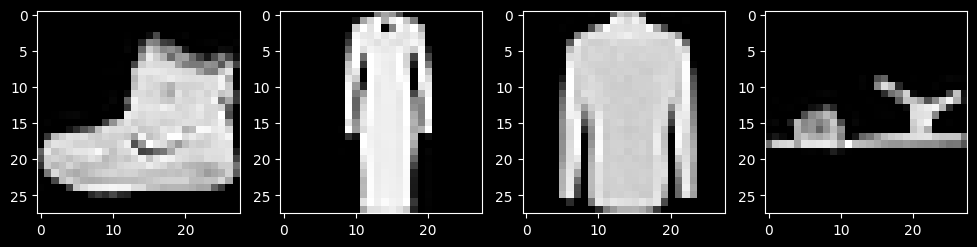

In [10]:
plt.figure(figsize=(3*image.shape[0], 3))
plt.axis('off')

for i in range(image.shape[0]):
    plt.subplot(1, image.shape[0], i+1) #* (rows, columns, image number)
    plt.imshow(image[i][0], cmap='gray')
    #plt.axis('off')
    

In [11]:
def get_index_from_list(list, t, image_shape):
    batch_size = t.shape[0] #* get the batch size
    out = list.gather(-1, t.cpu()) #* gather the values from the list & move to cpu
    #* reshape the output to match the shape of the input.
    out = out.reshape(batch_size, *((1,)) * (len(image_shape) - 1)).to(t.device) 
    return out

def diffusion_model_sampling(
    image, 
    t, 
    sqrt_alphas_cumpord,
    sqrt_one_minus_alphas_cumpord,
    device = "cpu",
    torch_seed = 42
):  
    torch.manual_seed(torch_seed)
    #* initialize the noise
    noise = torch.randn_like(image)
    
    #* get the sqrt of alphas cumpord at time t
    sqrt_alphas_cumpord_t = get_index_from_list(sqrt_alphas_cumpord, t, image.shape)
    
    #* get the sqrt of one minus alphas cumpord at time t
    sqrt_one_minus_alphas_cumpord_t = get_index_from_list(sqrt_one_minus_alphas_cumpord, t, image.shape)
    
    image_part = sqrt_alphas_cumpord_t.to(device) * image.to(device)
    noise_part = sqrt_one_minus_alphas_cumpord_t.to(device) * noise.to(device)
    
    noisy_image_t = image_part + noise_part
    return noisy_image_t, noise_part
    
    


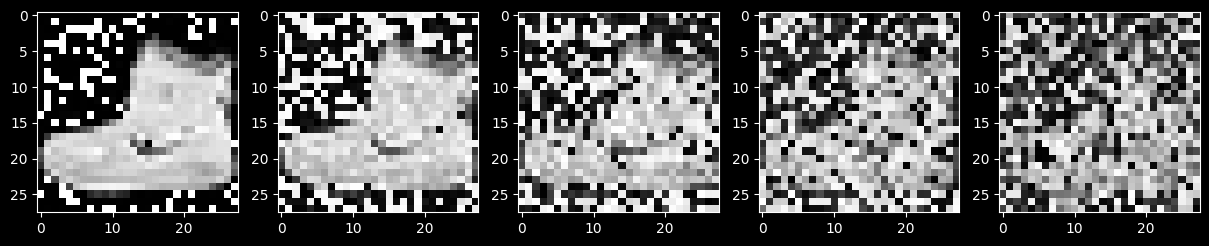

In [12]:
num_images = 5
step_size = int(T/num_images)
plt.figure(figsize=(3*num_images, 3))
plt.axis('off')
for idx in range(0, T , step_size):
    t = torch.tensor([idx]).type(torch.int64)
    x_t, _ = forward_diffusion_sample(image[0][0], t)
    plt.subplot(1, num_images, int(idx/step_size)+1)
    plt.imshow(reverse_transforms(x_t), cmap='gray')
    

In [13]:
def get_index_from_list(val, t, x_shape):
    """
    returns a specific index from a passed list of values
    while maintaining the shape of the original list
    """
    batch_size = t.shape[0] #* get the batch size
    out = val.gather(-1, t.cpu()) #* gather the values from the list & move to cpu
    #* reshape the output to match the shape of the input.
    return out.reshape(batch_size, *((1,)) * (len(x_shape) - 1)).to(t.device)

In [14]:
torch.manual_seed(42)
val1_tensor = Alphas_sqrt_cumpord
val2_tensor = Alphas_sqrt_one_minus_cumprod

t = torch.tensor([0])
X_0 = image[0][0]


noise = torch.randn_like(X_0)
sampled_val1 = get_index_from_list(val1_tensor, t, X_0.shape)
sampled_val2 = get_index_from_list(val2_tensor, t, X_0.shape)
print(sampled_val1, sampled_val2 )#* sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod

noisy_x1 = sampled_val1*X_0 + sampled_val2*noise

#x_t.cpu().detach().numpy()
# plt.imshow(reverse_transforms(noisy_x1), cmap='gray')

tensor([[0.9999]]) tensor([[0.0100]])


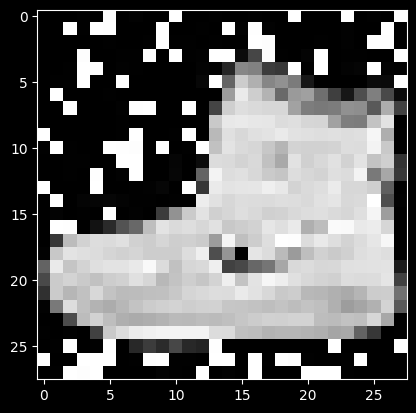

In [15]:
num_images = 5
step_size = int(T/num_images)
t = torch.Tensor([0]).type(torch.int64)
stepsize = int(T/num_images)
img, noise = forward_diffusion_sample(image[0][0], t)

plt.imshow(reverse_transforms(img), cmap='gray')


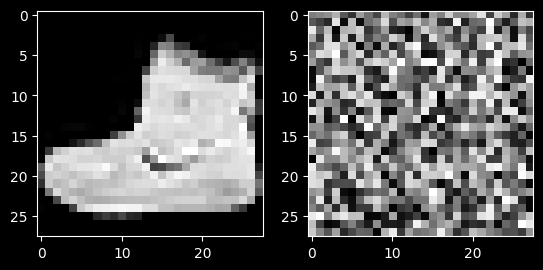

In [16]:
x_0 = data.data[0].float() / 255.0 #* get the first image
noisy = torch.rand_like(x_0) #* returns a tensor with the same shape as x_0

plt.subplot(1,2,1)
plt.imshow(x_0, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(noisy, cmap='gray')



## Paramerterized Backward Process
- we start in with mean zero and variance one
$$
P_{\theta}(x_0) = \mathcal{N}(x_0; 0, I)
$$

- in the sequence, the transition from one timestep to the next is predicted 

$$
P_{\theta}(x_{0:T}) = P(x_T)\prod_{t=1}^T P_{\theta}(x_{t-1}|x_{t})
$$

- iterate from xT to x0, 
- the denisty P(xT) is defined by the predicted gaussian noise in the distribution of image
- in order to get the we subtract the predicted noise from the image at the previous timestep during the forward pass(sampling)
$$
x_{t-1} \approx x_t - Noise
$$

## Positional embedding in pytorch
used to embed the timestep as additional information to the model
- let dim = 4 (dimension of the embedding)
- let T = 4 (number of timesteps)


- $ d = \frac{dim}{2} = 4$
- $ drange = {x : 0, 1, ..., d}$

the pytorch positional embedding is defined as
$$
    n = \frac{\log_2{10000}}{d-1}
$$

$$ 
    R = \exp{^{drainge * -n}} , shape = (d)
$$


$$
    Pos = T * R , shape = (T, R)
$$ 

$$
    Pos = [Cos(Pos), Sin(Pos)], shape = (T, dim)

$$

In [32]:
from torch import nn
import math
import numpy as np
class SinsoidalPositionalEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, timestep): 
        #* get the device of the timestep
        device = timestep.device 
        
        #* get the half of the dimension
        half_dim = self.dim // 2 
        
        #* calculate the frequency #* 2^i / 10000^(2i/d)
        embeddings = math.log(10000) / (half_dim - 1)
        
        #* calculate the embeddings
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings) 
        embeddings = timestep[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        
        return embeddings

        

In [35]:
size = 32 
timestep = torch.arange(size).type(torch.float32)
pos_embedding = SinsoidalPositionalEmbeddings(28*28)
time_embedding = pos_embedding(timestep)
time_embedding.shape


torch.Size([32, 784])

## UNET Model
 - Block


In [27]:
from torch import nn
import torch
import numpy as np
from torchsummary import summary
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up = False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch) #* time embedding
        
        #* for upsampling blocks
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
            
        #* for downsampling blocks
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        
        #* defining rest of the layers 
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        
    def forward(self, x, t):
        #* first conv 
        h = self.relu(self.conv1(x))
        h = self.bnorm1(h)
        
        # #* time embedding
        time_emb = self.time_mlp(t)
        time_emb = self.relu(time_emb)
        

        # #* extend last 2 dimensions for broadcasting
        time_emb = time_emb[(..., ) + (None, ) * 2] #* (3,4) -> (3,4,1,1) 
        
        # #* add time embedding to the output of the first conv
        h = h + time_emb
        
        # #* second conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        
        h = self.transform(h)
        return h


In [28]:
image  = torch.randn(1, 1, 28, 28)
time = torch.randn(1, 1)
print(image.shape, time.shape)
block1 = Block(
    in_ch = 1,
    out_ch = 16,
    time_emb_dim = 1,
    up = False
)

img = block1(image, time)
img.shape


try : summary(
    model=block1,
    input_size= [(1, 64, 64), (1,)],
    device='cpu',
    batch_size=10
    
)
except Exception as e:
    print("Ignore the error, summary works fine.")

torch.Size([1, 1, 28, 28]) torch.Size([1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [10, 16, 64, 64]             160
              ReLU-2           [10, 16, 64, 64]               0
       BatchNorm2d-3           [10, 16, 64, 64]              32
            Linear-4                   [10, 16]              32
              ReLU-5                   [10, 16]               0
            Conv2d-6           [10, 16, 64, 64]           2,320
              ReLU-7           [10, 16, 64, 64]               0
       BatchNorm2d-8           [10, 16, 64, 64]              32
            Conv2d-9           [10, 16, 64, 64]           2,320
Ignore the error, summary works fine.


In [29]:
## * UNet


class Diffusion_Unet(nn.Module):
    def __init__(self):
        super().__init__()

        image_channels = 1  # * grayscale image
        down_block_channels = (32, 64, 128, 256)
        up_channels = (256, 128, 64, 32)
        self.time_emb_dim = 32
        out_dim = 1

        # * Time Embedding
        self.time_mlp = nn.Sequential(
            SinsoidalPositionalEmbeddings(self.time_emb_dim),  # * positional embeddings
            nn.Linear(self.time_emb_dim, self.time_emb_dim),  # * linear layer
            nn.ReLU(),  # * activation
        )

        # * Initial Convolution
        self.conv0 = nn.Conv2d(
            image_channels, down_block_channels[0], kernel_size=3, padding=1
        )

        # * Downsampling Blocks
        self.downs = nn.ModuleList(
            [
                Block(
                    in_ch=down_block_channels[i],
                    out_ch=down_block_channels[i + 1],
                    time_emb_dim=self.time_emb_dim,
                )
                for i in range(len(down_block_channels) - 1)
            ]
        )

        # * Upsampling Blocks
        self.ups = nn.ModuleList(
            [
                Block(
                    in_ch=up_channels[i],
                    out_ch=up_channels[i + 1],
                    time_emb_dim=self.time_emb_dim,
                    up=True,
                )
                for i in range(len(up_channels) - 1)
            ]
        )

        # * Output Convolution
        self.output = nn.Conv2d(up_channels[-1], out_dim, kernel_size=3, padding=1)

    # * forward pass
    def forward(self, x, t):
        # * Ebmedding time
        t = self.time_mlp(t)

        # * Initial Convolution
        x = self.conv0(x)
        
        #* Unet
        residual_input = []
        #* append the input of each down block to the list
        for down in self.downs:
            x = down(x,t)
            residual_input.append(x)
            
        #* pop the last element from the list
        for up in self.ups:
            x = down(x,t)
            x = torch.cat((x, residual_input.pop()), dim=1)
            x = up(x)
            
        #* output
        x = self.output(x)
        return x
            

In [30]:
import torch
from torchsummary import summary

model = Diffusion_Unet()
model = model.to('cuda')
# print("Num params: ", sum(p.numel() for p in model.parameters()))

summary(
    model=model,
    input_size= [(1, 64, 64), (model.time_emb_dim,)],
    device='cuda',
    batch_size=1
    
)
try : summary(
    model=model,
    input_size= [(1, 64, 64), (32,)],
    device='cuda',
    batch_size=1
    )
except Exception as e:
    print("Ignore the error, summary works fine.")
    

RuntimeError: The size of tensor a (32) must match the size of tensor b (16) at non-singleton dimension 2

In [ ]:
timesteps = torch.arange(T)
image[0][0].shape

dim = image[0][0].shape[0] * image[0][0].shape[1]
positional_embeddings = SinsoidalPositionalEmbeddings(dim = image[0][0].shape[0] * image[0][0].shape[1])

positional_embeddings.dim
time_embeddings = positional_embeddings(timesteps)


In [ ]:
t = torch.randint(0, T, (BATCH_SIZE,), device='cpu').long()
t

tensor([18, 24, 18, 18])

In [ ]:
image[0][0].type(), timesteps.type()

('torch.FloatTensor', 'torch.LongTensor')